# Header

In [147]:
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
#%matplotlib notebook

import numpy as np
import scipy as s

In [2]:
# Check directory
os.chdir("D:\Raphael\Dropbox\Mcgill\JupyterNotebook\PHYS512")
os.getcwd()

'D:\\Raphael\\Dropbox\\Mcgill\\JupyterNotebook\\PHYS512'

# Functions

In [123]:
# Generate random inital condition
def init_cond(n):
    x=np.random.rand(n,3)
    v=np.random.rand(n,3)*0
    m=np.ones(n)/n
    return x,v,m

In [128]:
# Generate random inital condition
def init_cond_centered(n):
    x=np.random.rand(n,3)*2-1
    v=np.random.rand(n,3)*0
    m=np.ones(n)/n
    return x,v,m

In [151]:
# Define single ptcl softened potential (softened green's function), given a density matrix shape
def soft_pot(rho,edge,a):
    pot =rho*0 #initialise potential matrix
    nx = len(rho[0]) # number of bins in x
    ny = len(rho[1])
    nz = len(rho[2])
    dx = edge[0][1]-edge[0][0] # size of bin in x
    dy = edge[1][1]-edge[1][0]
    dz = edge[2][1]-edge[2][0]
    centerx = (edge[0][-1]-edge[0][0])/2 # center of x axis
    centery = (edge[1][-1]-edge[1][0])/2
    centerz = (edge[2][-1]-edge[2][0])/2
    for i in range(nx):
        for j in range(ny):
            for k in range(nz): # looking at some bin i,j,k
                x = (i+0.5)*dx-centerx # position of the center of the bin in x, given ptcl at x=0.5 (i.e at the center, since x=[0,1) )
                y = (j+0.5)*dy-centery
                z = (k+0.5)*dz-centerz
                r = np.sqrt(x**2+y**2+z**2) # distance btw center of bin and and particle
                if r**3<=a:
                    pot[i,j,k] = r/a # potential for bins close to ptcl
                else:
                    pot[i,j,k] = 1/r**2 # potential for bins far from ptcl
    return pot

In [143]:
# define function for easy visual check (thanks Marcus!)
def plot_2D_collapse(H,edges):
    edges_x = edges[0]
    edges_y = edges[1]
    edges_z = edges[2]
    fig,ax = plt.subplots(figsize=(10,10), dpi=100)
    im = ax.imshow(
        H.sum(axis=2),
        origin="lower",
        extent=(edges_y.min(), edges_y.max(), edges_x.min(), edges_x.max()), 
        aspect="auto")
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    minor_ticks_x = edges_x
    minor_ticks_y = edges_y
    ax.set(xlim=(minor_ticks_y[0], minor_ticks_y[-1]), ylim=(minor_ticks_x[0], minor_ticks_x[-1]))
    ax.set_xticks(minor_ticks_y, minor=True)
    ax.set_yticks(minor_ticks_x, minor=True)

    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    plt.show

In [107]:
#Return a 3D plot of the given x
def plot_graph3D(x, title ="", scale_factor = 1,save=False, name = "fig",n = 0):
    #Create figure
    fig=plt.figure(figsize=(10,10))#Create 3D axes
    ax=Axes3D(fig) 
    ax.scatter(x[0], x[1], x[2], color="royalblue", marker=".",s=.02*scale_factor)
    ax.set_xlabel("x-coordinate",fontsize=14)
    ax.set_ylabel("y-coordinate",fontsize=14)
    ax.set_label("z-coordinate",fontsize=14)
    ax.set_title(title,fontsize=20)
    #ax.legend(loc="upper left",fontsize=14)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    if save:
        plt.savefig('Pictures_Final_Project/{}{}.png'.format(name,n), dpi=100)
    plt.close(fig)

# Code

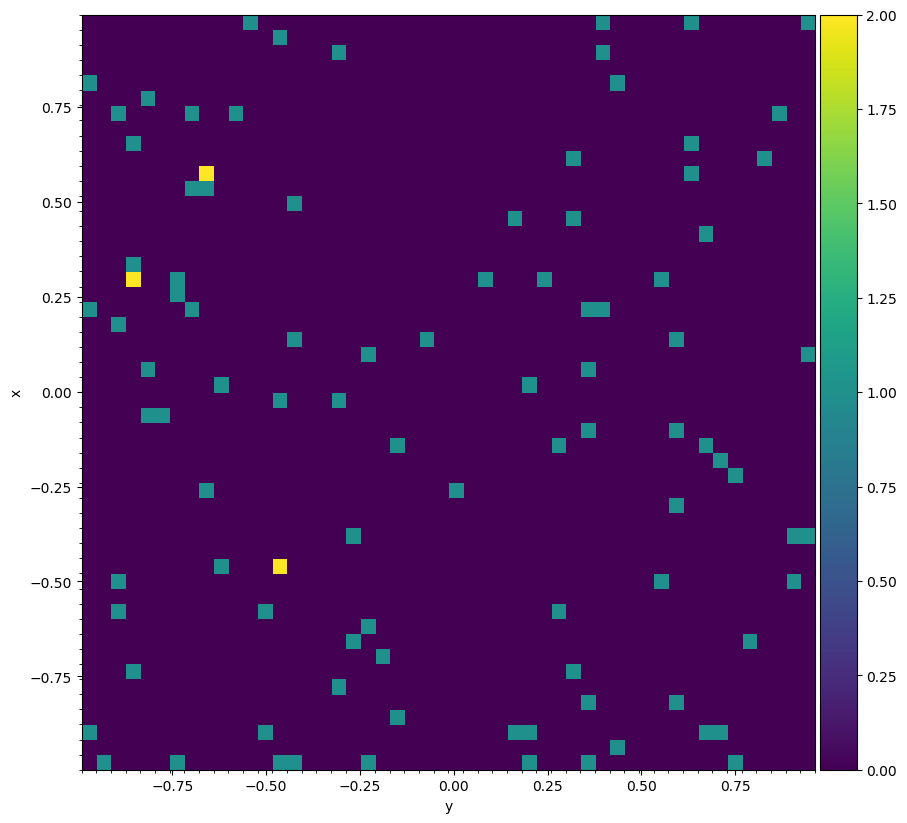

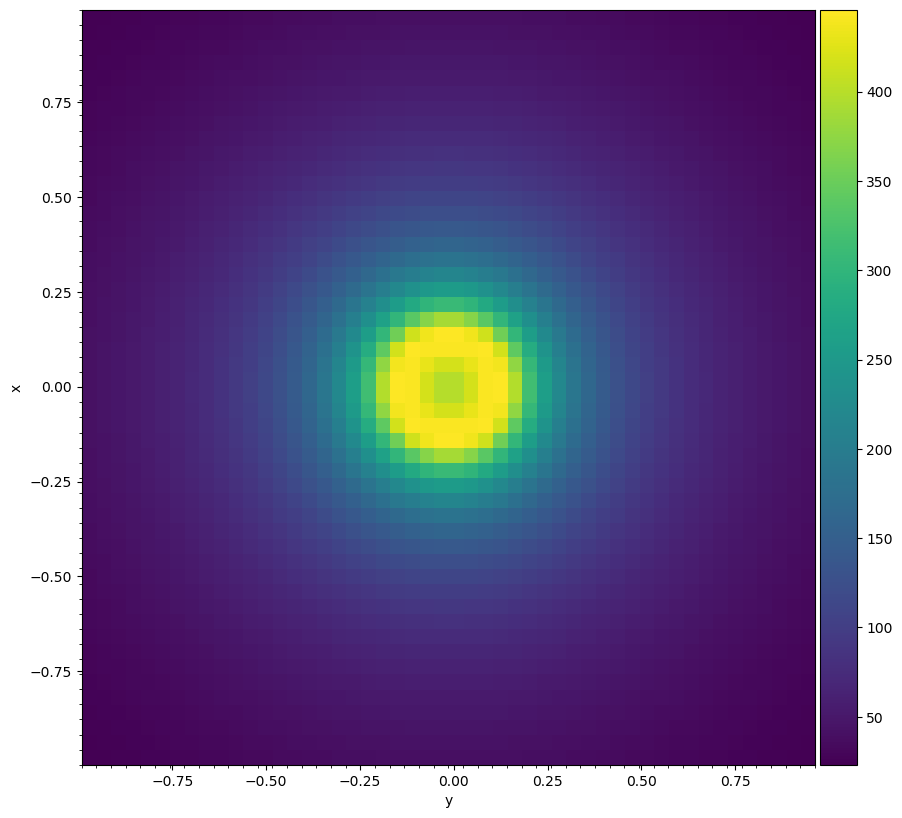

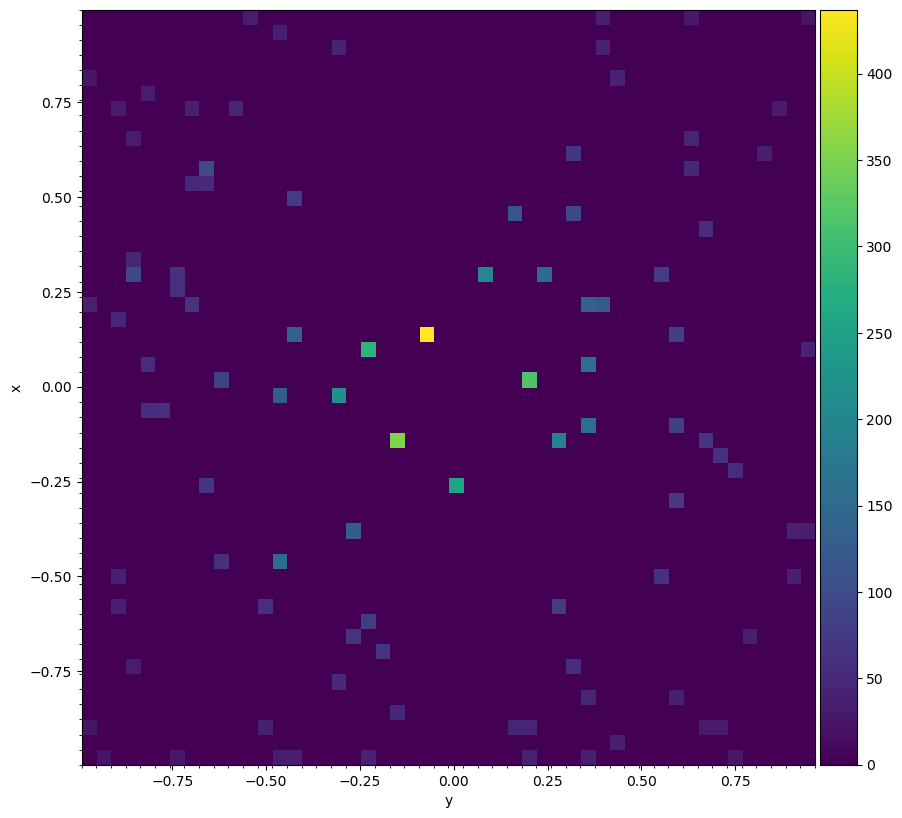

In [152]:
# initialise randomly for some n ptcls in a box size^3
n = 100
size = 50
x,v,m = init_cond_centered(n)

# Create density matrix rho
rho,edge = np.histogramdd(x,bins=size)
plot_2D_collapse(rho,edge)

# Create softened potential matrix s_pot
greens_f = soft_pot(rho,edge,0.005)
plot_2D_collapse(greens_f,edge)

# Compute total potential matrix by convolving the density matrix with the softened potential
phi = np.fft.ifft(np.fft.fft(greens_f) * np.fft.fft(rho))
#phi = np.fft.fftshift(phi)
plot_2D_collapse(phi.real,edge)

# Compute the acceleration matrix by taking the gradient of the potential
acc = np.gradient(phi)

# Define timestep
dt = 0.1

In [30]:
#x[ptcl,xyz]
#x_t[xyz,ptcl]

In [153]:
def plot(bin_edges_x, bin_edges_y, x, y, field, fx, fy, plot_scatter=True, plot_quiver=True, grid=True, cmap="viridis"):
    """
    A useful function for plotting parameters for the nbody assignment
    
    Most variables should be self explanatory.
    
    field should be for example the density field, potential field, forces... Whatever
    you think would be helpful to plot :)
    
    (fx, fy) are only for if you want to quiver plot and should be the force for each particle
    arranged in the same order as (x,y)
    """
    fig,ax = plt.subplots(figsize=(10,10), dpi=100)
    minor_ticks_x = bin_edges_x
    minor_ticks_y = bin_edges_y
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.set(xlim=(minor_ticks_x[0], minor_ticks_x[-1]), ylim=(minor_ticks_x[0], minor_ticks_x[-1]))
    if grid:
        ax.grid(which='minor', alpha=0.75, color='xkcd:grey')
    if plot_scatter:
        scat = ax.scatter(x, y, color='k', s=10)
    cax = ax.imshow(
        field,
        # Extent goes (left, right, bottom, top)
        origin="lower",
        extent=(minor_ticks_x[0], minor_ticks_x[-1], minor_ticks_y[0], minor_ticks_y[-1]), 
        cmap=cmap
    )
    if plot_quiver:
        qax = ax.quiver(
            x, 
            y,
            fx, 
            fy,
            units="x",
            width=0.005*len(bin_edges_x),
            color="w"
        )
    
    plt.show()